<a href="https://colab.research.google.com/github/kwonzero/artists_classification/blob/main/kwonzero/cutmix%2BCrossEntropylLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 베이스라인 + cutmix + CrossEntropyLoss + image size 조정
* Efficient-net B2, batch_size=32
* result
    - train loss : 0.80631
    - validation loss : 0.95046
    - f1 score : 0.72630
    - epoch : 60
    - 0.6885835261 -> Public 64위
    - 0.681566585 -> Private 44위

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00


In [2]:
import gc
import random
from datetime import datetime

import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
CFG = {
    'IMG_SIZE': 260,
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-3,
    'BATCH_SIZE': 32,
    'PATIENCE': 10,
    'SEED': 6
}

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [6]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Project/CV/dataset/'
else:
    data_path = '../../data/'

Mounted at /content/drive


In [7]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df.loc[3896, 'artist'] = 'Titian'
df.loc[3986, 'artist'] = 'Alfred Sisley'
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [8]:
artists = df.groupby('artist')[['id']].count().rename(columns={'id':'count'}).reset_index()

In [9]:
# Label Encoding
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=CFG['SEED'])

In [11]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
1,1,./train/0001.jpg,48
3,3,./train/0003.jpg,10
4,4,./train/0004.jpg,24
6,6,./train/0006.jpg,43


In [12]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist
2,2,./train/0002.jpg,7
5,5,./train/0005.jpg,38
10,10,./train/0010.jpg,6
11,11,./train/0011.jpg,1
18,18,./train/0018.jpg,33


In [13]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values
    return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values, df['artist'].values

In [14]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [15]:
from torchvision.transforms import ToTensor


class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms if transforms else ToTensor()

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']

        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_paths)

In [16]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(p=1,height=CFG['IMG_SIZE'],width=CFG['IMG_SIZE']),
    A.Transpose(p=0.5), # 행렬 스왑
    A.HorizontalFlip(p=0.5), # 좌우 반전
    A.VerticalFlip(p=0.5), # 상하 반전
    # A.ShiftScaleRotate(p=0.5), # 랜덤하게 옮기고, scale, 회전
    # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5), # 빛깔, 색조, 값 변환
    # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5), # 명도 대비
    # A.ChannelShuffle(), # RGB 채널 간 shuffle
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    # A.CoarseDropout(p=0.5),
    ToTensorV2()
])

validation_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(p=1,height=CFG['IMG_SIZE'],width=CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

In [17]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

In [18]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=4)

val_dataset = CustomDataset(val_img_paths, val_labels, validation_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=4)

In [19]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = timm.create_model('efficientnet_b2', pretrained=True, num_classes=512)
        self.classifier = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [20]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

## CutMix

In [21]:
for X, y in train_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 3, 260, 260])
torch.Size([32])


In [22]:
def rand_bbox(size, lam):   # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = np.int(W * cut_rat)  # 패치의 너비
    cut_h = np.int(H * cut_rat)  # 패치의 높이

    # uniform
    # 기존 이미지의 크기에서 랜덤하게 값을 가져옵니다.(중간 좌표 추출)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

# 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

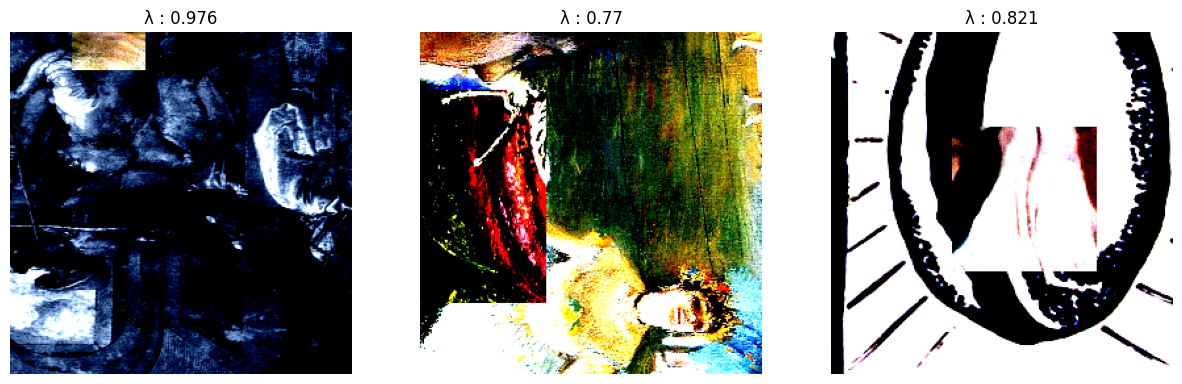

In [23]:
import matplotlib.pyplot as plt
def cutmix_plot(train_loader):
    fig , axes = plt.subplots(1,3)
    fig.set_size_inches(15,12)

    for i in range(3):
        for inputs, targets in train_loader:
            inputs = inputs
            targets = targets
            break

        lam = np.random.beta(1.0, 1.0)  # 베타 분포에서 lam 값을 가져옵나다.
        rand_index = torch.randperm(inputs.size()[0])   # batch_size 내의 인덱스가 랜덤하게 셔플됩니다.
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
        axes[i].imshow(inputs[1].permute(1, 2, 0).cpu())
        axes[i].set_title(f'λ : {np.round(lam,3)}')
        axes[i].axis('off')
    return

cutmix_plot(train_loader)

In [24]:
def train(model, optimizer, criterion, train_loader, device, beta=1, cutmix_prob=0.5):
    model.train()
    train_loss = []
    bar = tqdm(enumerate(train_loader), total = len(train_loader), desc='Train Loop')
    for idx, (img, label) in bar:
        img, label = img.float().to(device), label.long().to(device)

        optimizer.zero_grad()
        r = np.random.rand(1)
        if beta > 0 and r < cutmix_prob:
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(img.size()[0]).cuda()
            target_a = label
            target_b = label[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]

            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))

            model_pred = model(img)
            loss = criterion(model_pred, target_a) * lam + criterion(model_pred, target_b) * (1. - lam)
            loss.backward()
            optimizer.step()
        else:
            model_pred = model(img)
            loss = criterion(model_pred, label)
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())
        bar.set_postfix(train_loss = f'{loss.item():.4f}')
    return np.mean(train_loss)

In [25]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation(model, criterion, test_loader, device):
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for img, label in iter(test_loader):
            img, label = img.float().to(device), label.long().to(device)

            model_pred = model(img)

            loss = criterion(model_pred, label)

            val_loss.append(loss.item())

            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [26]:
time_now = datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M%S")
os.makedirs(os.path.join(data_path, f'./runs/{run_id}'), exist_ok=True)
print(f'{run_id=}')

run_id='20231215131713'


In [27]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         else:
#             return focal_loss

In [28]:
def train_epoch(model, optimizer, train_loader, test_loader, scheduler, device):
    model.to(device)

    # criterion = FocalLoss(alpha=1, gamma=2).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    early_stopping = EarlyStopping(patience=CFG['PATIENCE'], verbose=True)

    best_score = 0

    for epoch in range(1,CFG["EPOCHS"]+1):
        tr_loss = train(model, optimizer, criterion, train_loader, device)
        val_loss, val_score = validation(model, criterion, test_loader, device)

        if scheduler is not None:
            scheduler.step()

        if best_score < val_score:
            print(f'**Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
            best_score = val_score
            torch.save(model, os.path.join(data_path, f'runs/{run_id}/best_model.pt'))
        else:
            print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        clear_mem()
        if early_stopping(val_score):
            print(f'Epoch [{epoch}], early stopping')
            break

In [29]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        return self.early_stop

In [30]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None
# train_epoch(model, optimizer, train_loader, val_loader, scheduler, device)
train_epoch(model, optimizer, train_loader, val_loader, scheduler, device)

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [1], Train Loss : [2.75093] Val Loss : [2.16857] Val F1 Score : [0.26602]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [2], Train Loss : [2.15245] Val Loss : [1.63416] Val F1 Score : [0.41204]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [3], Train Loss : [1.91137] Val Loss : [1.59820] Val F1 Score : [0.48667]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [4], Train Loss : [1.61564] Val Loss : [1.41977] Val F1 Score : [0.53204]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [5], Train Loss : [1.56854] Val Loss : [1.30172] Val F1 Score : [0.57998]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.49536] Val Loss : [1.27635] Val F1 Score : [0.57144]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.5799841058936734


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [7], Train Loss : [1.43797] Val Loss : [1.16982] Val F1 Score : [0.59424]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [8], Train Loss : [1.42751] Val Loss : [1.17452] Val F1 Score : [0.59853]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [9], Train Loss : [1.35285] Val Loss : [1.18963] Val F1 Score : [0.59069]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.5985345697175096


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [10], Train Loss : [1.27161] Val Loss : [1.23080] Val F1 Score : [0.60962]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [11], Train Loss : [1.22903] Val Loss : [1.28557] Val F1 Score : [0.62101]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [12], Train Loss : [1.33648] Val Loss : [1.06537] Val F1 Score : [0.66351]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [13], Train Loss : [1.22364] Val Loss : [1.03986] Val F1 Score : [0.67646]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [14], Train Loss : [1.07971] Val Loss : [1.16914] Val F1 Score : [0.65209]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6764632411747362


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [15], Train Loss : [1.15555] Val Loss : [1.20835] Val F1 Score : [0.63293]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6764632411747362


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [16], Train Loss : [1.14775] Val Loss : [1.18368] Val F1 Score : [0.65035]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.6764632411747362


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [17], Train Loss : [1.06311] Val Loss : [1.33287] Val F1 Score : [0.64042]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.6764632411747362


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [18], Train Loss : [1.09215] Val Loss : [1.15802] Val F1 Score : [0.69661]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [19], Train Loss : [1.00685] Val Loss : [1.19377] Val F1 Score : [0.62841]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6966109509943418


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.99708] Val Loss : [1.15681] Val F1 Score : [0.66232]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6966109509943418


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [21], Train Loss : [1.00885] Val Loss : [0.96553] Val F1 Score : [0.70757]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [22], Train Loss : [0.94870] Val Loss : [0.99402] Val F1 Score : [0.70798]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.92601] Val Loss : [1.07071] Val F1 Score : [0.66676]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7079756601706007


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.87556] Val Loss : [1.16518] Val F1 Score : [0.67417]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7079756601706007


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.90988] Val Loss : [1.06129] Val F1 Score : [0.69907]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7079756601706007


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.83433] Val Loss : [1.03463] Val F1 Score : [0.68498]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.7079756601706007


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.93554] Val Loss : [1.02780] Val F1 Score : [0.69761]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.7079756601706007


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [28], Train Loss : [0.81836] Val Loss : [1.04368] Val F1 Score : [0.70882]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.92058] Val Loss : [1.04722] Val F1 Score : [0.69531]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.708815447855491


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.88113] Val Loss : [0.97459] Val F1 Score : [0.68446]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.708815447855491


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.78770] Val Loss : [1.08663] Val F1 Score : [0.66449]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.708815447855491


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.93122] Val Loss : [1.19423] Val F1 Score : [0.67720]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.708815447855491


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.84330] Val Loss : [0.98211] Val F1 Score : [0.68423]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.708815447855491


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.86287] Val Loss : [1.02374] Val F1 Score : [0.67945]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.708815447855491


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [35], Train Loss : [0.81801] Val Loss : [1.03160] Val F1 Score : [0.71129]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.77106] Val Loss : [1.07613] Val F1 Score : [0.69789]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.711288829515736


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.74887] Val Loss : [1.08034] Val F1 Score : [0.69465]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.711288829515736


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.73976] Val Loss : [1.16688] Val F1 Score : [0.70820]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.711288829515736


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.85571] Val Loss : [1.06913] Val F1 Score : [0.67445]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.711288829515736


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.78962] Val Loss : [1.11326] Val F1 Score : [0.69839]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.711288829515736


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.76161] Val Loss : [1.07909] Val F1 Score : [0.67703]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.711288829515736


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.83350] Val Loss : [1.00265] Val F1 Score : [0.68476]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.711288829515736


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.75036] Val Loss : [1.02761] Val F1 Score : [0.69565]
EarlyStopping counter: 8 out of 10
Best F1 score from now: 0.711288829515736


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [44], Train Loss : [0.70089] Val Loss : [0.97633] Val F1 Score : [0.72160]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.67242] Val Loss : [1.13002] Val F1 Score : [0.68680]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7216004298390619


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.87171] Val Loss : [1.03488] Val F1 Score : [0.68462]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7216004298390619


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.80491] Val Loss : [1.01859] Val F1 Score : [0.68942]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7216004298390619


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.75842] Val Loss : [1.04330] Val F1 Score : [0.70837]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.7216004298390619


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.73490] Val Loss : [1.09752] Val F1 Score : [0.69511]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.7216004298390619


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [50], Train Loss : [0.80631] Val Loss : [0.95046] Val F1 Score : [0.72630]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [51], Train Loss : [0.73790] Val Loss : [1.05034] Val F1 Score : [0.69704]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [52], Train Loss : [0.70287] Val Loss : [1.09088] Val F1 Score : [0.70127]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [53], Train Loss : [0.70258] Val Loss : [1.04689] Val F1 Score : [0.72058]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [54], Train Loss : [0.70137] Val Loss : [1.10700] Val F1 Score : [0.70505]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [55], Train Loss : [0.67918] Val Loss : [0.98797] Val F1 Score : [0.70546]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [56], Train Loss : [0.70570] Val Loss : [1.04639] Val F1 Score : [0.70145]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [57], Train Loss : [0.71016] Val Loss : [1.03013] Val F1 Score : [0.68550]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [58], Train Loss : [0.69197] Val Loss : [1.00833] Val F1 Score : [0.69191]
EarlyStopping counter: 8 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [59], Train Loss : [0.69791] Val Loss : [0.94144] Val F1 Score : [0.72511]
EarlyStopping counter: 9 out of 10
Best F1 score from now: 0.7263049348192766


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [60], Train Loss : [0.66880] Val Loss : [1.08423] Val F1 Score : [0.68477]
EarlyStopping counter: 10 out of 10
Best F1 score from now: 0.7263049348192766
Epoch [60], early stopping


In [31]:
# 1. train, Val 1/4 하지 말고 batch_size=32로 실험
# 2. CrossEntropyLoss + batch_size=32로 실험
test_df = pd.read_csv(os.path.join(data_path, './test.csv'))
test_df.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [32]:
test_img_paths = get_data(test_df, infer=True)

In [33]:
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=4)

In [34]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()

    model_preds = []

    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.float().to(device)

            model_pred = model(img)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()

    print('Done.')
    return model_preds

In [35]:
checkpoint = os.path.join(data_path, f'runs/{run_id}/best_model.pt')
print(f'CHECKPOINT LOADED: {checkpoint}')
infer_model = torch.load(checkpoint)
infer_model.to(device)
infer_model.eval()

CHECKPOINT LOADED: /content/drive/MyDrive/Project/CV/dataset/runs/20231215131713/best_model.pt


BaseModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1,

In [36]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/396 [00:00<?, ?it/s]

Done.


In [37]:
preds = le.inverse_transform(preds)

In [38]:
submit = pd.read_csv(os.path.join(data_path, './sample_submission.csv'))

In [39]:
submit['artist'] = preds

In [40]:
submit.head()

,id,artist
0,TEST_00000,Jan van Eyck
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Titian
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Edgar Degas


In [41]:
submit.to_csv(os.path.join(data_path, './submit.csv'), index=False)